# Exploration of the E-MFD 

In this notebook, we explore the E-MFD for usage within Affect Misattribution Procedures (`AMP`) and Lexical Decision Tasks (`LDT`). 

In [1]:
import pandas as pd
import numpy as np

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from functions import make_wordclouds

# NLP
import spacy, re, fnmatch 
nlp = spacy.load('en')

plt.style.use('seaborn-paper')
sns.set_style('whitegrid')
plt.rcParams['font.serif'] = "Times New Roman"

In [2]:
amp = pd.read_pickle('dictionaries/emfd_amp.pkl')
probabilities = [c for c in amp.columns if c.endswith('_p')]

### 1) Construct WordClouds for Highest Weighted Words

In [3]:
foundations = ['care','fairness','loyalty','authority','sanctity']

In [4]:
# Add vice, virtue columns        
virtues = [f+'.virtue' for f in foundations]
vices = [f+'.vice' for f in foundations]

for f in virtues:
    amp[f] = 0.0
for f in vices:
    amp[f] = 0.0

# Transfer weights to vice-virtue columns
for i, row in amp.iterrows():
    if row['ind_comp'] < 0:
        amp.at[i,'care.vice'] = row.care_p
        amp.at[i,'fairness.vice'] = row.fairness_p
        amp.at[i,'loyalty.vice'] = row.loyalty_p
        amp.at[i,'authority.vice'] = row.authority_p
        amp.at[i,'sanctity.vice'] = row.sanctity_p
    else :
        amp.at[i,'care.virtue'] = row.care_p
        amp.at[i,'fairness.virtue'] = row.fairness_p
        amp.at[i,'loyalty.virtue'] = row.loyalty_p
        amp.at[i,'authority.virtue'] = row.authority_p
        amp.at[i,'sanctity.virtue'] = row.sanctity_p
        
amp['foundation'] = amp[virtues+vices].idxmax(axis=1).astype(str)

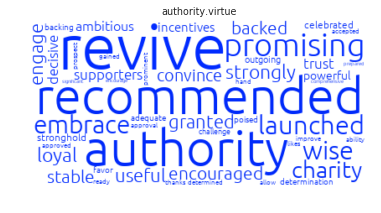

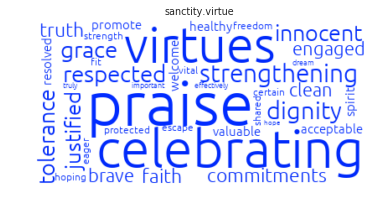

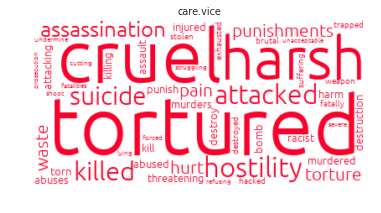

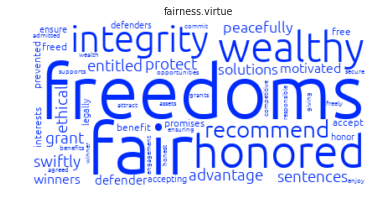

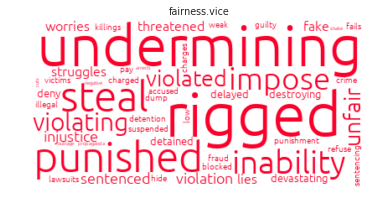

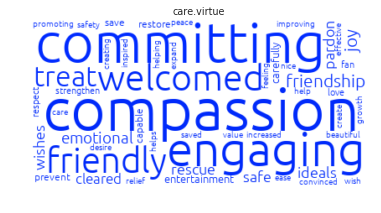

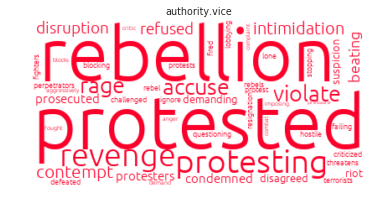

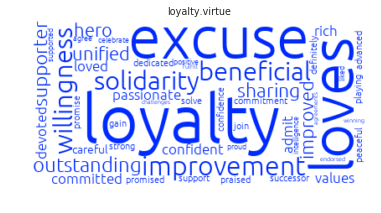

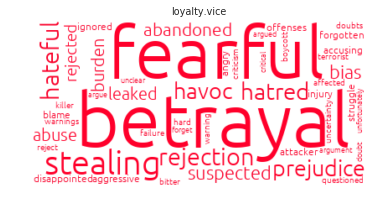

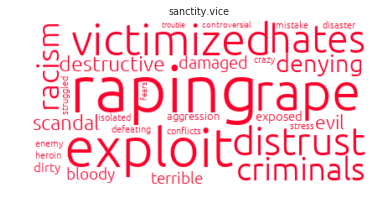

In [5]:
make_wordclouds(amp)

Text(0, 0.5, 'Foundation')

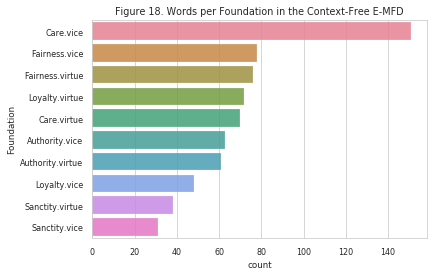

In [9]:
g =sns.countplot(y='foundation',data=amp, order=amp.foundation.value_counts().index, palette='husl', alpha=0.85)
labels = [item.get_text().capitalize() for item in g.get_yticklabels()]
g.set_yticklabels(labels)
plt.title("Figure 18. Words per Foundation in the Context-Free E-MFD")
plt.ylabel('Foundation')

In [7]:
amp.to_pickle('dictionaries/emfd_amp.pkl')

### 2) Compare weights across foundations in E-MFD Scoring

In [5]:
emfd = pd.read_pickle('dictionaries/emfd_scoring.pkl')

Text(0.5, 1.0, 'Figure 15. Part of Speech Tags in the E-MFD')

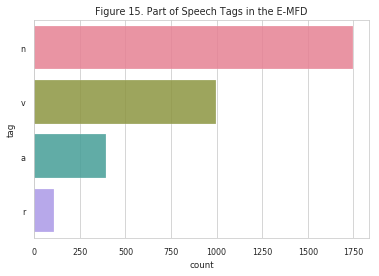

In [6]:
sns.countplot(y='tag',data=emfd, order=emfd.tag.value_counts().index, palette='husl', alpha=0.85)
plt.title("Figure 15. Part of Speech Tags in the E-MFD")

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

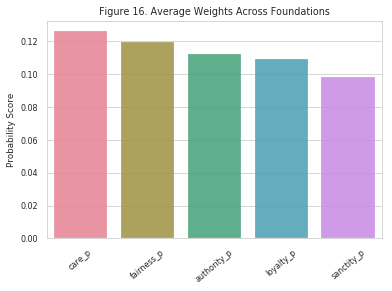

In [7]:
sns.barplot(x='index', y=0, data = emfd[probabilities].mean().reset_index(), order=emfd[probabilities].mean().sort_values(ascending=False).index, palette='husl', alpha=0.85)
plt.title('Figure 16. Average Weights Across Foundations')
plt.ylabel('Probability Score')
plt.xlabel('')
plt.xticks(rotation=40)

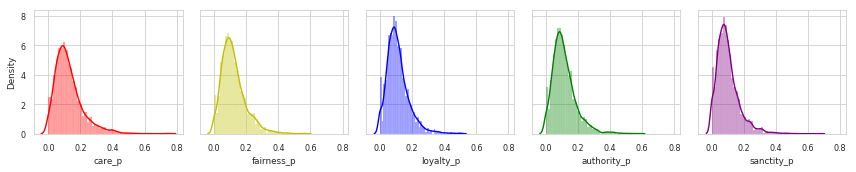

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,2.5), sharey=True, sharex=True)
sns.distplot(emfd['care_p'], ax=ax[0], color='r')
sns.distplot(emfd['fairness_p'], ax=ax[1], color='y')
sns.distplot(emfd['loyalty_p'], ax=ax[2], color='blue')
sns.distplot(emfd['authority_p'], ax=ax[3], color='green')
sns.distplot(emfd['sanctity_p'], ax=ax[4], color='purple')
ax[0].set_ylabel('Density')
plt.tight_layout()

## 3) Comparison with MFD

In [22]:
# Assign highest foundation
emfd['foundation'] = emfd[probabilities].idxmax(axis=1).astype(str)

In [24]:
MFD = 'dictionaries/mft_original.dic'
nummap = dict()
mfd = dict()
mfd_regex = dict()
wordmode = True
with open(MFD, 'r') as f:
    for line in f.readlines():
        ent = line.strip().split()
        if line[0] == '%':
            wordmode = not wordmode
        elif len(ent) > 0:
            if wordmode:
                mfd[ent[0]] = [nummap[e] for e in ent[1:]]
            else:
                nummap[ent[0]] = ent[1]

# convert vocab to compiled regex for comparison
for v in mfd.keys():
    mfd_regex[v] = re.compile(fnmatch.translate(v))

In [44]:
match_mfd = pd.DataFrame(columns=['word','f_mfd', 'f_emfd'])

for i,row in emfd.iterrows():
    for v in mfd_regex.keys():
        if mfd_regex[v].match(row['word']):
            match_mfd.at[i, 'word'] = row['word']
            match_mfd.at[i, 'f_emfd'] = row['foundation']
            for f in mfd[v]:
                match_mfd.at[i, 'f_mfd'] = f
                
# Add probabilties and sentiment from emfd
sent_cols = [c for c in emfd.columns if c.endswith('_pos') or c.endswith('neg') or c.endswith('neu')]
match_mfd = match_mfd.join(emfd[probabilities+sent_cols], on='word')

# Assign foundation of MFD number to correlate with probabilities of E-MFD
mfd_founds = pd.get_dummies(match_mfd['f_mfd'])
match_mfd = pd.concat([match_mfd, mfd_founds],axis=1)
foundations = ['care.virtue','care.vice','fairness.virtue','fairness.vice','loyalty.virtue','loyalty.vice',
               'authority.virtue','authority.vice','sanctity.virtue','sanctity.vice']

In [65]:
len(match_mfd)

196

Text(0.5, 13.899999999999999, 'e-MFD Foundation Probabilities')

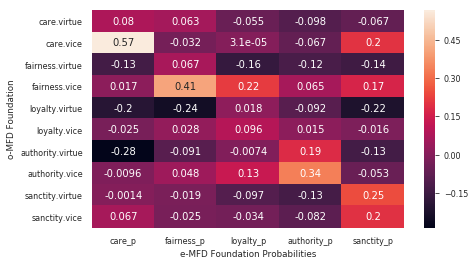

In [68]:
fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(match_mfd.corr()[probabilities].loc[foundations], annot=True)
plt.ylabel('o-MFD Foundation')
plt.xlabel('e-MFD Foundation Probabilities')

## 3) Comparison with MFD2.0 

In [74]:
# Initiate MFD2.0 
MFD2 = 'dictionaries/mfd2.0.dic'
nummap = dict()
mfd2 = dict()
wordmode = True
with open(MFD2, 'r') as f:
    for line in f.readlines():
        ent = line.strip().split()
        if line[0] == '%':
            wordmode = not wordmode
        elif len(ent) > 0:
            if wordmode:
                wordkey = ''.join([e for e in ent if e not in nummap.keys()])
                mfd2[wordkey] = [nummap[e] for e in ent if e in nummap.keys()]
            else:
                nummap[ent[0]] = ent[1]

mfd2 = pd.DataFrame.from_dict(mfd2).T
mfd2['foundation'] = mfd2[0]
del mfd2[0]
mfd2 = mfd2.T.to_dict()

In [93]:
match_mfd2 = pd.DataFrame(columns=['word','f_mfd2', 'f_emfd'])

for i,row in emfd.iterrows():
    if row['word'] in mfd2.keys():
        match_mfd2.at[i, 'word'] = row['word']
        match_mfd2.at[i, 'f_emfd'] = row['foundation']
        match_mfd2.at[i, 'f_mfd2'] = mfd2[row['word']]['foundation']
    
                
# Add probabilties and sentiment from emfd
match_mfd2 = match_mfd2.join(emfd[probabilities], on='word')

# Assign foundation of MFD number to correlate with probabilities of E-MFD
mfd_founds = pd.get_dummies(match_mfd2['f_mfd2'])
match_mfd2 = pd.concat([match_mfd2, mfd_founds],axis=1)
foundations = ['care.virtue','care.vice','fairness.virtue','fairness.vice','loyalty.virtue','loyalty.vice',
               'authority.virtue','authority.vice','sanctity.virtue','sanctity.vice']

In [94]:
len(match_mfd2)

279

Text(0.5, 13.899999999999999, 'e-MFD Foundation Probabilities')

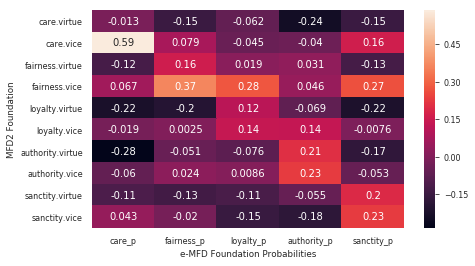

In [98]:
fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(match_mfd2.corr()[probabilities].loc[foundations], annot=True)
plt.ylabel('MFD2 Foundation')
plt.xlabel('e-MFD Foundation Probabilities')